# Housing data analysis 

## Objectives

## Data download and structure

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
# downloading data
import os
import tarfile
import urllib

# set up paths
DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2/raw/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [3]:
import pandas as pd

# set up download data function
def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    os.makedirs(housing_path,  exist_ok = True)
    tgz_path = os.path.join(housing_path,  "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()

# loading data function
def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
# try to load data, if data was not downloaded, go to exception
try:
    # load data
    housing = load_housing_data()
except:
    # download data
    fetch_housing_data()
    # load data
    housing = load_housing_data()    

In [5]:
# data structure
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Some insights we already can get from the structure:
1. There are 20,640 instances.
2. 207 regions lack `total_bedrooms` data.
3. `ocean_proximity` probably is categoric.

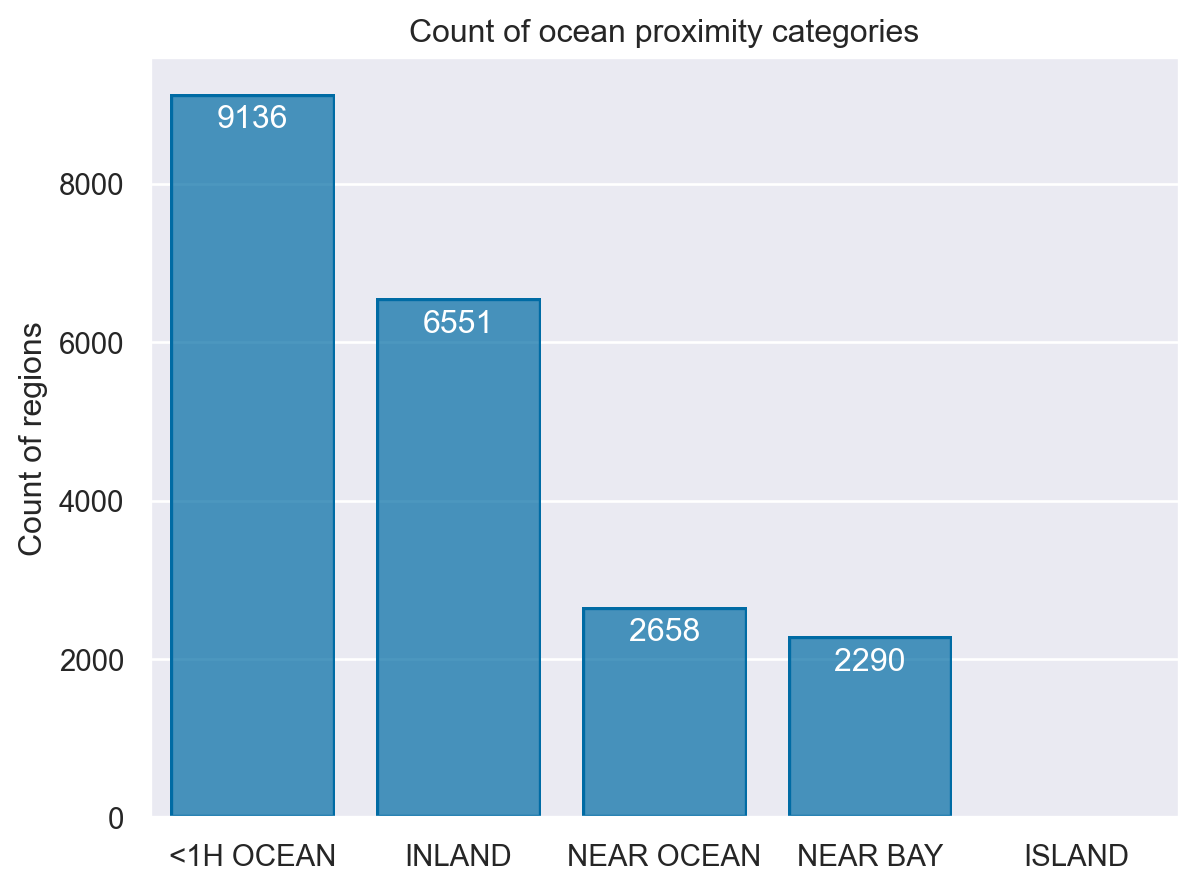

In [7]:
# identify categories and count in ocean_proximity
import seaborn.objects as so
from matplotlib import style
import warnings

# ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

vc = housing["ocean_proximity"].value_counts()
(
    so.Plot(x = vc.index, y = vc, text = vc)
    .add(so.Bar())
    .add(so.Text(color = "w", valign = "top"))
).\
    label(title = "Count of ocean proximity categories"
          , x = "" 
          , y = "Count of regions").\
          theme({**style.library["tableau-colorblind10"]})

There are more regions `< 1H OCEAN` than `INLAND`. This can be included for later analysis.

In [ ]:
# summary of numeric data
housing.describe()

: 

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins = 50, figsize = (20, 15))
plt.show()

: 

## Test set

In [ ]:
from sklearn.model_selection import train_test_split

: 